### Tuning hyper-paremter of cortical cell classifier

In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/')

from constants import * 
from base import *
from custom_metrics import *
from tuning_cv import *

In [2]:
## Importing libraries 
import pandas as pd
import numpy as np 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

### Importing data 

In [3]:
# Annotated cells 
cell_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Cortex/cells/"
cell_training = "training.txt"

# NNB information of all cells on slide
nnb_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Cortex/NNB/"
nnb_training = "training_NNB.txt"

# hema nucleus of all cells on slide
hema_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Cortex/hema/"
hema_training = "training_hema.txt"

Require: 
1. input_files.txt - to contian filenames I want to use. ** currently .csv files

In [4]:
# Importing annotated cells 

# obtaining list of files 
with open(cell_path + cell_training) as f: 
    mylist= f.read().splitlines()
    
print("Read in: ",len(mylist),"files")

# reading in all those files 
inputs = [] 
for i in mylist: 
    dat_ = pd.read_csv(cell_path + i,sep=",")
    dat_.columns.values[5] = 'Centroid_X'
    dat_.columns.values[6] = 'Centroid_Y'
    dat = dat_[cell_extracted_features] # fixed extracted feature order
    inputs.append(dat)
print("Extracted:", len(inputs),"files")


Read in:  12 files
Extracted: 12 files


In [5]:
# Importing in neghbouring cells info (numbers)

with open(nnb_path + nnb_training) as f: 
    nb_mylist= f.read().splitlines()
    
print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")

# reading in all those files 
nb_inputs = []
nb_columns = [] 
for i in nb_mylist: 
    dat = pd.read_csv(nnb_path +i,sep=",")
    dat.columns.values[0] = 'X'
    dat.columns.values[1] = 'Y'
    nb_inputs.append(dat)
    nb_columns.append(dat.shape[1])
    
print("Extracted:", len(nb_inputs),"files")
print('no. of columns / NB file:', nb_columns)

Read in: 12  NUMBER OF neighbouring cells files
Extracted: 12 files
no. of columns / NB file: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [6]:
#  Importing hema nucleus mean of all detected cells & location coordinates 
# Variables: hema_mylist, hema_inputs 

## obtaining list of files 
with open(hema_path + hema_training) as f: 
    hema_mylist= f.read().splitlines()
    
print("Read in:",len(hema_mylist),"hema files")    


## 4) reading in all those files 
hema_inputs = [] 
for i in hema_mylist: 
    dat = pd.read_csv(hema_path + i,sep=",")
    dat.columns.values[0] = 'Centroid_X' # To fix naming inconsistency problem 
    dat.columns.values[1] = 'Centroid_Y'
    hema_inputs.append(dat)

print("Extracted:",len(hema_inputs),"hema files")  


Read in: 12 hema files
Extracted: 12 hema files


In [7]:
# Checking if filenames & order of them from mylist, nb_mylist & hema_mylist match
x_nb = [i[1:7] for i in nb_mylist]
x = [i[0:6] for i in mylist]
x_h = [i[0:6] for i in hema_mylist]
print("mylist & nb_list matched?:", x==x_nb)
print("mylist & hema_list matched?:",x==x_h)

mylist & nb_list matched?: True
mylist & hema_list matched?: True


In [8]:
# combine cells with NNB information
inputs_with_nbb, output_log = combine_annotated_to_NNB(annotated_list = inputs,
                                                        NNB_list = nb_inputs)
print(output_log)

[True, True, True, True, True, True, True, True, True, True, True, True]


In [9]:
# Find cells to remove based on hematoxylin staining (from normalisation, remove top 1%)
hema_to_remove = find_hema_to_remove(hema_inputs)

# for i in range(0,len(hema_to_remove)): 
#     print(i, " No. of cells with normalised Hema >1:",len(hema_to_remove[i]), "from", len(hema_inputs[i]),"detected cells")

In [10]:
# remove cells that have hema above criteria
cleaned_inputs, remove_log = remove_cell_hema(inputs_with_nbb,
                                              hema_to_remove)
print(remove_log)
print(cleaned_inputs[0].shape)

[True, True, True, True, True, True, True, True, True, True, True, True]
(566, 51)


### Putting the slides together 

In [11]:
##Variables: labelled_orig, labelled_data 
#1) Put the slides together

labelled_orig = pd.concat(cleaned_inputs)
print(labelled_orig.shape)

# 2) Extract relevant columns 
dat = labelled_orig.drop(columns=['Name','Parent','ROI']) 
dat.head()


(4717, 51)


,Image,Class,Centroid_X,Centroid_Y,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,703484.svs,fragmented,2758.4,5064.2,0.7102,10.4438,11.7588,0.9492,1.0000,4.2279,...,1,2,3,5,7,10,16,21,25,36
1,703484.svs,Epithelial,2865.6,5210.4,0.7737,34.4719,24.9365,0.6966,0.9739,10.6183,...,0,1,3,3,4,7,14,25,32,35
2,703484.svs,Epithelial,2929.0,5210.6,0.7337,23.0844,20.5225,0.6888,0.9821,8.7795,...,0,0,1,2,5,5,10,15,18,25
3,703484.svs,Ignore,2736.6,5224.5,0.5949,31.9419,20.3826,0.9662,1.0000,7.1633,...,0,0,0,1,7,13,15,20,28,35
4,703484.svs,fragmented,5262.3,5460.8,0.7159,9.8636,13.0301,0.7300,0.9790,5.4442,...,1,4,7,8,13,16,17,19,22,30


### Extracting relevant cell classes

In [12]:
# Make all class names lower case - easier for later selection

dat_lower_class = [i.lower() for i in dat['Class']]
dat2 = dat.copy()
dat2.loc[:,'Class'] = dat_lower_class 
dat2['Class'].value_counts()

neuron_new        885
oligo_new         792
epithelial_new    557
ignore            356
ignore_new        344
epithelial        330
fragmented        304
neuron            302
astro             297
oligo             295
astro_new         179
stardist_error     35
fragmented_new     25
tumor              16
Name: Class, dtype: int64

In [13]:
# Select only relevant cell classes (Using stardist_error instead of ignore_new)
dat3 = dat2[(dat2['Class'] == 'oligo_new') | (dat2['Class'] == 'neuron_new')
          | (dat2['Class'] == 'astro_new')| (dat2['Class'] == 'epithelial_new')
          | (dat2['Class'] == 'stardist_error')| (dat2['Class'] == 'fragmented_new')]
dat3=dat3.reset_index(drop=True)

# Checking results
dat3['Class'].value_counts()

neuron_new        885
oligo_new         792
epithelial_new    557
astro_new         179
stardist_error     35
fragmented_new     25
Name: Class, dtype: int64

In [14]:
# Re-name these classes so it has no '_new'
class_new = dat3['Class']
x = [(i[0:-4].capitalize()) for i in class_new]
#dat = dat_ 
dat3['Class'] = x
dat3['Class'].value_counts()

Neuron        885
Oligo         792
Epithelial    557
Astro         179
Stardist_e     35
Fragmented     25
Name: Class, dtype: int64

In [15]:
# Group Ignore, Epithelial & Fragmented cells as a single class called 'ta'
class_ = dat3['Class']
y = ['Others' if i == 'Epithelial' or i == 'Stardist_e' or i == 'Fragmented' else i for i in class_ ]
data = dat3
data['Class'] = y 
print(data['Class'].value_counts().sum())
data['Class'].value_counts()


2473


Neuron    885
Oligo     792
Others    617
Astro     179
Name: Class, dtype: int64

In [16]:
# Export cleaned data out for easy use: 
# path = '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Cell_classification/cortical_training_data.txt'
# data.to_csv(path, sep="\t", index=False)

# Training the model

### Checking for any NA in the data

In [17]:
#checking for NAN 
## NEW 
print("Any NA in the data?: ",data.isnull().sum().sum()==1)

#dat = dat.dropna()
#dat.isnull().sum().sum()

Any NA in the data?:  False


### Create train, test sets 

In [18]:
#We are using the entire dataset to train the model, test data will be provided later by Sanne 
X_train_l = data.drop(columns=['Class'])
X_train = X_train_l.drop(columns=['Image','Centroid_X','Centroid_Y'])
print('training data shape:',X_train.shape)
y_train = data['Class']

training data shape: (2473, 44)


In [19]:
X_train.head()

,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,Nucleus: Min diameter µm,Cell: Area µm^2,Cell: Length µm,Cell: Circularity,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,0.8929,70.4335,30.1589,0.9731,1.0000,10.5379,8.6989,258.8036,60.0120,0.9030,...,0,2,3,7,9,12,14,18,28,36
1,0.6650,69.3602,30.0618,0.9645,1.0000,10.3145,8.9289,289.4437,60.9183,0.9801,...,0,3,4,8,8,9,17,22,27,35
2,0.9025,21.2553,16.7824,0.9483,1.0000,6.1317,4.5305,132.4307,42.3046,0.9299,...,0,2,4,5,10,13,15,18,22,35
3,0.7240,91.2679,34.9913,0.9367,0.9992,12.8068,8.8117,321.6940,65.4879,0.9426,...,0,2,2,5,8,14,19,26,33,40
4,0.8682,18.5580,15.5796,0.9608,1.0000,5.4150,4.4888,163.2746,45.8910,0.9743,...,0,0,1,7,12,15,17,22,28,37


In [20]:
pipeline_cell

Pipeline(steps=[('normalizer', MinMaxScaler()),
                ('selector',
                 RFE(estimator=RandomForestClassifier(random_state=42))),
                ('clf', BalancedRandomForestClassifier())])

### Hyperparameter tuning - linear SVM

In [21]:
pipeline_cell_linearSVM

Pipeline(steps=[('normalizer', MinMaxScaler()),
                ('selector',
                 RFE(estimator=SVC(kernel='linear', random_state=42))),
                ('clf', SVC(kernel='linear', random_state=42))])

In [22]:
grid_linearSVM

{'selector__n_features_to_select': [28, 30, 34, 36, 38, 40, 42, 44],
 'clf__C': [10, 1, 10, 100],
 'clf__class_weight': ['balanced']}

In [23]:
# # Create the random grid 

rf_random = GridSearchCV(pipeline_cell_linearSVM,
                         param_grid=grid_linearSVM, 
                        cv=10,
                        refit='f1_macro', # use this metric to evaluate performance of parameters 
                        scoring={
                        'balanced_accuracy':'balanced_accuracy',
                        'f1_macro':'f1_macro',
                          'f1_weighted':'f1_weighted',
                          'Astro_accuracy': astro_acc,
                          'Neuron_accuracy':neuron_acc,
                          'Oligo_accuracy':oligo_acc,
                          'Others_accuracy':others_acc,
                          'A_as_N':A_as_N,
                          'A_as_O':A_as_O,
                          'A_as_Others':A_as_Others,
                          'N_as_A':N_as_A,
                          'N_as_O':N_as_O,
                          'N_as_Others':N_as_Others,
                          'O_as_A':O_as_A,
                          'O_as_N':O_as_N,
                          'O_as_Others':O_as_Others,
                          'Others_as_A':Others_as_A,
                          'Others_as_N':Others_as_N,
                          'Others_as_O':Others_as_O
                        })

rf_random.fit(X_train,y_train)

print(rf_random.best_score_)
print(rf_random.best_params_)


0.7643214557334472
{'clf__C': 10, 'clf__class_weight': 'balanced', 'selector__n_features_to_select': 42}


In [25]:
# # Digging into more details 

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_macro:",
      rf_random.cv_results_['mean_test_f1_macro'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("Astrocyte accuracy:",
      rf_random.cv_results_['mean_test_Astro_accuracy'][rf_random.best_index_]*100)

print("Neuron accuracy:",
      rf_random.cv_results_['mean_test_Neuron_accuracy'][rf_random.best_index_]*100)

print("Oligo accuracy:",
      rf_random.cv_results_['mean_test_Oligo_accuracy'][rf_random.best_index_]*100)

print("Others accuracy:",
      rf_random.cv_results_['mean_test_Others_accuracy'][rf_random.best_index_]*100)


print("Classified A as N:",
      rf_random.cv_results_['mean_test_A_as_N'][rf_random.best_index_]*100)

print("Classified A as O:",
      rf_random.cv_results_['mean_test_A_as_O'][rf_random.best_index_]*100)

print("Classified A as Others:",
      rf_random.cv_results_['mean_test_A_as_Others'][rf_random.best_index_]*100)

print("Classified N as A:",
      rf_random.cv_results_['mean_test_N_as_A'][rf_random.best_index_]*100)

print("Classified N as O:",
      rf_random.cv_results_['mean_test_N_as_O'][rf_random.best_index_]*100)

print("Classified N as Others:",
      rf_random.cv_results_['mean_test_N_as_Others'][rf_random.best_index_]*100)

print("Classified O as A:",
      rf_random.cv_results_['mean_test_O_as_A'][rf_random.best_index_]*100)

print("Classified O as N:",
      rf_random.cv_results_['mean_test_O_as_N'][rf_random.best_index_]*100)

print("Classified O as Others:",
      rf_random.cv_results_['mean_test_O_as_Others'][rf_random.best_index_]*100)


print("Classified Others as A:",
      rf_random.cv_results_['mean_test_Others_as_A'][rf_random.best_index_]*100)

print("Classified Others as N:",
      rf_random.cv_results_['mean_test_Others_as_N'][rf_random.best_index_]*100)

print("Classified Others as O:",
      rf_random.cv_results_['mean_test_Others_as_O'][rf_random.best_index_]*100)
                                                       

Balanced accuracy: 81.06713875029406
F1_macro: 76.43214557334473
F1_weighted: 81.81270435152975
Astrocyte accuracy: 84.28104575163398
Neuron accuracy: 83.37589376915219
Oligo accuracy: 83.08702531645571
Others accuracy: 73.52459016393442
Classified A as N: 6.111111111111112
Classified A as O: 4.575163398692809
Classified A as Others: 5.032679738562091
Classified N as A: 11.98544433094995
Classified N as O: 0.5669050051072523
Classified N as Others: 4.071756894790603
Classified O as A: 7.200949367088608
Classified O as N: 0.379746835443038
Classified O as Others: 9.332278481012658
Classified Others as A: 7.295081967213113
Classified Others as N: 6.517715494447383
Classified Others as O: 12.662612374405075


In [26]:
# save object using joblib
joblib.dump(rf_random, 'cortical_linear_SVM_gridSearch.sav')

['cortical_linear_SVM_gridSearch.sav']

## Manual cross validation, using PR curves

In [27]:
cortical_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(estimator=SVC(random_state=42,
                                   kernel='linear'),
        n_features_to_select=42)),
    ('clf', SVC(
        random_state=42,
        kernel='linear',
        C=10,
        class_weight='balanced'))]
        
# 10-fold cross validation
model = ClassifierTuning(hyperparameters=cortical_classifier_hyperparams)


In [28]:
model.cv_nothresholding(X=X_train,
                        Y=y_train,
                        X_location= X_train_l)

In [29]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
cf = sum(model.cv_confusion_matrices)
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100
print(cf)
print(final_cm)
print("--------------------------")
print("Astro accuracy",final_cm[0][0])
print("Neuron accuracy",final_cm[1][1])
print("Oligo accuracy",final_cm[2][2])
print("Others accuracy",final_cm[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reports])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reports])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reports])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reports])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reports])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reports])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reports])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reports])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 81.06713875029408
Macro avg F1  76.43214557334473
Weighted avg F1  81.81270435152975
--------------------------
[[151  11   8   9]
 [106 738   5  36]
 [ 57   3 658  74]
 [ 45  40  78 454]]
[[84.3575419   6.1452514   4.46927374  5.02793296]
 [11.97740113 83.38983051  0.56497175  4.06779661]
 [ 7.1969697   0.37878788 83.08080808  9.34343434]
 [ 7.29335494  6.48298217 12.64181524 73.58184765]]
--------------------------
Astro accuracy 84.35754189944134
Neuron accuracy 83.38983050847457
Oligo accuracy 83.08080808080808
Others accuracy 73.58184764991897
------------------------------
Astro f1-score  56.622314754485615
Astro precision  43.314917956898945
Astro recall  84.28104575163398
--------------------------
Neuron f1-score  87.91965180151371
Neuron precision  93.33642029319458
Neuron recall  83.3758937691522
--------------------------
Oligo f1-score  85.0795640514514
Oligo precision  88.14812294034185
Oligo recall  83.0870253164557
--------------------------
Others

In [30]:
# save object using joblib
joblib.dump(model, 'cortical_linear_SVM_cv_results.sav')

['cortical_linear_SVM_cv_results.sav']

In [31]:
cortical_classifier_hyperparams

[('normalizer', MinMaxScaler()),
 ('selector',
  RFE(estimator=SVC(kernel='linear', random_state=42), n_features_to_select=42)),
 ('clf', SVC(C=10, class_weight='balanced', kernel='linear', random_state=42))]

In [32]:
# Train final model
cortical_model = Pipeline(cortical_classifier_hyperparams)
final_model = cortical_model.fit(X_train,y_train)

In [33]:
joblib.dump(final_model, 'cortical_linear_SVM_classifier.sav')

['cortical_linear_SVM_classifier.sav']

Extracting information

In [34]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Comparing_methods/cortical_linear_SVM_cv_results.sav')
cf_t = sum(loaded_model.cv_confusion_matrices)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100

In [35]:
final_cm_t

array([[84.3575419 ,  6.1452514 ,  4.46927374,  5.02793296],
       [11.97740113, 83.38983051,  0.56497175,  4.06779661],
       [ 7.1969697 ,  0.37878788, 83.08080808,  9.34343434],
       [ 7.29335494,  6.48298217, 12.64181524, 73.58184765]])

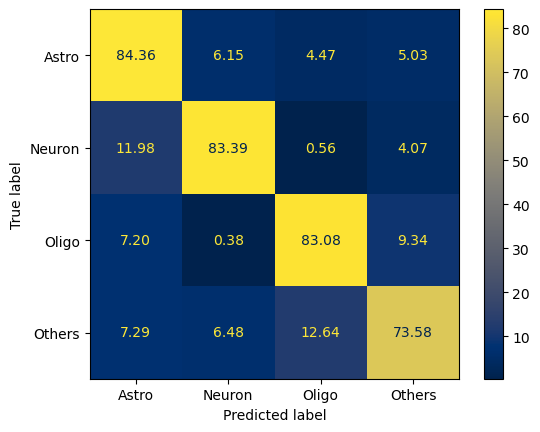

In [36]:
plot = ConfusionMatrixDisplay(final_cm_t,
                              display_labels=['Astro', 'Neuron', 'Oligo', 'Others'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [37]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  76.43214557334473
Macro avg F1 std  3.6935950374448865
--------------------------
Macro avg precision 76.05070556300956
Macro avg precision std 3.78755826625512
--------------------------
Macro avg recall  81.06713875029408
Macro avg recall std 2.7508038151096628


Plotting feature importance

In [38]:
import seaborn as sns

In [39]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Comparing_methods/cortical_linear_SVM_gridSearch.sav')

In [41]:
model_rf.best_params_
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [X_train.columns[i] for i in rf_result]
rf_result_f

['Detection probability',
 'Nucleus: Area µm^2',
 'Nucleus: Length µm',
 'Nucleus: Circularity',
 'Nucleus: Solidity',
 'Nucleus: Max diameter µm',
 'Nucleus: Min diameter µm',
 'Cell: Area µm^2',
 'Cell: Length µm',
 'Cell: Circularity',
 'Cell: Solidity',
 'Cell: Max diameter µm',
 'Cell: Min diameter µm',
 'Nucleus/Cell area ratio',
 'Hematoxylin: Nucleus: Mean',
 'Hematoxylin: Nucleus: Median',
 'Hematoxylin: Nucleus: Min',
 'Hematoxylin: Nucleus: Max',
 'Hematoxylin: Nucleus: Std.Dev.',
 'Hematoxylin: Cytoplasm: Mean',
 'Hematoxylin: Cytoplasm: Median',
 'Hematoxylin: Cytoplasm: Min',
 'Hematoxylin: Cytoplasm: Max',
 'Hematoxylin: Cytoplasm: Std.Dev.',
 'Hematoxylin: Membrane: Mean',
 'Hematoxylin: Membrane: Median',
 'Hematoxylin: Membrane: Min',
 'Hematoxylin: Membrane: Std.Dev.',
 'Hematoxylin: Cell: Mean',
 'Hematoxylin: Cell: Median',
 'Hematoxylin: Cell: Min',
 'Hematoxylin: Cell: Max',
 'Hematoxylin: Cell: Std.Dev.',
 'NN_10_um',
 'NN_20_um',
 'NN_30_um',
 'NN_40_um',
 'NN_